In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
import numpy as np

# ============================================================
# Repeat the relevant previous steps
# ============================================================

# Generate a graph
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
# Route flows (ground truth)
eoh = 4
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=42)
# Unfold
tug = util.build_time_unfolded_graph(g, eoh=eoh)
# Compute counts
node_counts, arc_counts = util.get_counts(tug, flows, paths)
# Solve the path formulation
rflows, rpaths = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=0)

# Symmetries

Sometimes metrics are not enough

## Unexpected Discrepancy

**Our current solution seems apparently perfect**

In [2]:
util.print_solution(tug, rflows, rpaths, sort='descending')
sse = util.get_reconstruction_error(tug, rflows, rpaths, node_counts, arc_counts)
print(f'RSSE: {np.sqrt(sse):.2f}')

8.17: 2,3 > 3,3
5.47: 0,2 > 1,2 > 2,2 > 3,2
3.74: 3,3
3.10: 0,1 > 1,1 > 2,0 > 3,0
1.79: 1,0 > 2,0 > 3,0
1.79: 0,1 > 1,1 > 2,0 > 3,2
1.53: 1,0 > 2,0 > 3,2
RSSE: 0.00


...And yet it _does not match_ the ground truth!

In [3]:
util.print_ground_truth(flows, paths, sort='descending')

8.17: 2,3 > 3,3
5.47: 0,2 > 1,2 > 2,2 > 3,2
4.89: 0,1 > 1,1 > 2,0 > 3,0
3.74: 3,3
3.32: 1,0 > 2,0 > 3,2


## Unexpected Discrepancy

**The discrepancy is unexpected, due to the 0 reconstruction error**

Indeed, we can check that the reconstructed counts match the true ones:

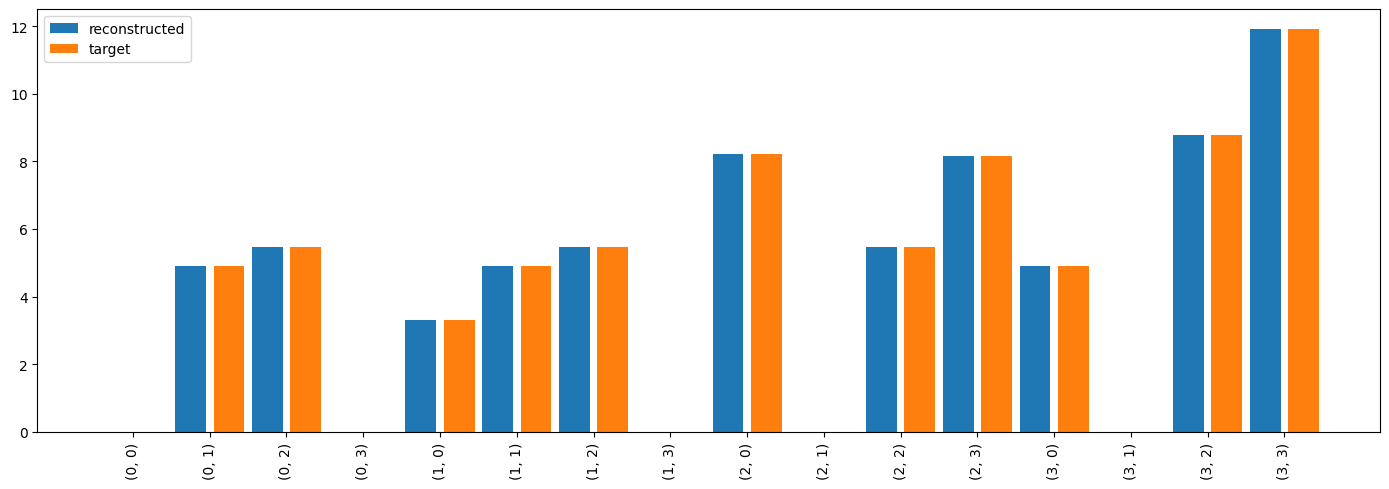

In [4]:
rnc, rac = util.get_counts(tug, rflows, rpaths)
util.plot_dict(rnc, figsize=figsize, label='reconstructed', data2=node_counts, label2='target', title='Node Counts')

## Unexpected Discrepancy

> **What is going on?**

**We mentioned early on that _the available information is poor_**

* There are many possible paths
* ...And many possible ways to explain the original counts!

> **How do we fix these _symmetries_?**

* The only way is adding external information (e.g. a preference on paths)
* We can view this as a form of regularization

## Occam's Razor

**Intuitively, we could give priority to _the simplest explanation_**

<center style="font-size:small">
<img src="assets/occam.png" width=250px/>
Image credit: <a href="https://xkcd.com/2541/">xkcd 2541</a>
</center>

A reasonable choice may be to use _a small number of paths_

> **How do we enforce this?**

## L1 Regularization and Path Number

**We may think of using an L1 regularization**

We would just need to add a linear term to the path formulation:
$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + q^T x + \alpha x \mid x \geq 0 \right\}
$$

...Which would translate into a correction on the $q$ vector:
$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + (q^T + \alpha) x \mid x \geq 0 \right\}
$$

* This trick is implemented in the `solve_path_selection_full` function
* We just need to pass a value for the `alpha` argument

## L1 Regularization and Path Number

**Let's begin by trying $\alpha = 1$**

In [5]:
rflows2, rpaths2 = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=0, alpha=1)
print('FLOW: PATH')
util.print_solution(tug, rflows2, rpaths2, sort='descending')
sse = util.get_reconstruction_error(tug, rflows2, rpaths2, node_counts, arc_counts)
print(f'\nRSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
8.10: 2,3 > 3,3
5.37: 0,2 > 1,2 > 2,2 > 3,2
2.97: 0,1 > 1,1 > 2,0 > 3,0
2.36: 3,3
1.66: 0,1 > 1,1 > 2,0 > 3,2
1.61: 1,0 > 2,0 > 3,0
1.40: 1,0 > 2,0 > 3,2
0.21: 0,1 > 1,1 > 2,0 > 3,3
0.17: 1,0 > 2,0 > 3,3
0.06: 1,0 > 2,3 > 3,3

RSSE: 1.32


* The RSSE grows (as it could be expcted)
* But we have _more_ paths!

## L1 Regularization and Path Number

**What if we make $\alpha$ larger?**

In [6]:
rflows2, rpaths2 = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=0, alpha=10)
print('FLOW: PATH')
util.print_solution(tug, rflows2, rpaths2, sort='descending')
sse = util.get_reconstruction_error(tug, rflows2, rpaths2, node_counts, arc_counts)
print(f'\nRSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
4.80: 2,3 > 3,3
4.26: 0,2 > 1,2 > 2,2 > 3,2
2.18: 0,1 > 1,1 > 2,0 > 3,0
1.31: 0,1 > 1,1 > 2,0 > 3,2
0.83: 1,0 > 2,3 > 3,3
0.58: 0,1 > 1,1 > 2,0 > 3,3
0.46: 1,0 > 2,0 > 3,0
0.38: 1,0 > 2,0 > 3,2
0.26: 1,0 > 2,0 > 3,3
0.14: 0,1 > 1,0 > 2,3 > 3,3
0.10: 0,1 > 1,0 > 2,0 > 3,0
0.09: 0,1 > 1,0 > 2,0 > 3,2
0.08: 0,1 > 1,0 > 2,0 > 3,3

RSSE: 9.13


* We don't seem to be getting _fewer_ paths, but rather _longer_ ones

## L1 Regularization and Path Number

**Shouldn't L1 norm work as a sparsifier?**

Not exactly: it simply results in a _fixed penalty rate_ for raising a variable

* The solver will try to _balance_ it with a larger reduction of the quadratic loss
* ...Which we can easily improve by including _more nodes_ in each path

**The truth is that when we use an L1 norm as sparsifier...**

...We really wished our regularizer to be:
$$
N_{paths} = \sum_{j=1}^n z_j \quad \text{with: } z_j = \left\{\begin{aligned}
1 & \text{ if $x_j > 0$} \\
0 & \text{ otherwise}
\end{aligned}\right.
$$

* Which is inconvenient, since it is non-differentiable
* ...But what if we used an approach for non-differentiable optimization?

# Path Consolidation Problem

Let's face an inconvenient truth

## Path Consolidation Problem

**For example, we could _focus on the paths in the current solution_:**

* ..._Minimize the number_ of used paths
* ...While preserving our reconstruction error

This is form of _symmetry breaking_ (as a post-processing step)

**By doing this, we obtain a _"path consolidation problem"_ in the form:**

$$\begin{align}
\arg \min_{x} \ & \|z\|_1 \\
\text{subject to: } & Vx = v^* \\
& Ex = e^* \\
& x \leq M z \\
& x \geq 0 \\
& z \in \{0, 1\}^n
\end{align}$$

## Path Consolidation Problem

**Let's proceed to examine the formulation a bit better:**

$$\begin{align}
\arg \min_{x} \ & \|z\|_1 \\
\text{subject to: } & Vx = v^* \\
& Ex = e^* \\
& x \leq M z \\
& x \geq 0 \\
& z \in \{0, 1\}^n
\end{align}$$

* The terms $V$, $E$, and $x$ are the same as before
* ...Except in this case we will consider a _a subset of the paths_
* $v^*$ and $e^*$ are the counts from the optimal path formulation solution
* We are requiring the (reconstructed) counts to be _exactly the same_

## Path Consolidation Problem

**Let's proceed to examine the formulation a bit better:**

$$\begin{align}
\arg \min_{x} \ & \|z\|_1 \\
\text{subject to: } & Vx = v^* \\
& Ex = e^* \\
& x \leq M z \\
& x \geq 0 \\
& z \in \{0, 1\}^n
\end{align}$$

* The $z$ variables determine whether a path is used ($z_j = 1$) or not ($z_j = 0$)
* $M$ is a constant large enough to make the constraint trivial if $z_j = 1$
* Constants such as these are often referred to as "big-Ms"
* Basically, $x \leq Mz$ is a linearization of the implication $x > 0 \Rightarrow z = 1$

## Path Consolidation Problem

**Let's proceed to examine the formulation a bit better:**

$$\begin{align}
\arg \min_{x} \ & \|z\|_1 \\
\text{subject to: } & Vx = v^* \\
& Ex = e^* \\
& x \leq M z \\
& x \geq 0 \\
& z \in \{0, 1\}^n
\end{align}$$

* All constraints are linear
* The cost function is linear
* Some variables are integer

**This is a _Mixed Integer Linear Program (MILP)_**